In [1]:
import pandas as pd

## Implement ICoNet

### Prepare Data

In [2]:
error_train_ideation = pd.read_csv('result/errors_pred_ideation.csv')
error_train_suicatt = pd.read_csv('result/errors_pred_suicatt.csv')

In [3]:
suicide_db = pd.read_csv('data/final.csv')

y = suicide_db['suicatt']
X = suicide_db[suicide_db.columns[[1,2,3,4,5,7,8,9,10,11,14,15,17,30,31]]]

In [4]:
def normalize(x):
  return (x - 13) / (17 - 13)

X['age'] = X['age'].apply(normalize)

C:\Users\PLour\AppData\Local\Temp\ipykernel_33744\2353473130.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['age'] = X['age'].apply(normalize)


In [5]:
# Train df
V = X.copy()
V['error_ideation'] = error_train_ideation
V['error_suicatt'] = error_train_suicatt
V[['ideation', 'suicatt']] = suicide_db[['ideation','suicatt']]



In [6]:
df_encoder_train = V.copy()
df_outs_train = df_encoder_train[['ideation', 'suicatt']]
df_features_train = df_encoder_train.drop(['error_suicatt', 'error_ideation','suicatt', 'ideation'], axis = 1)



df_encoder_test = V.copy()
df_outs_test = df_encoder_test[['ideation', 'suicatt']]
df_features_test = df_encoder_test.drop(['error_suicatt', 'error_ideation','suicatt', 'ideation'], axis = 1)

In [7]:
encoding_dim = 1
number_of_features = len(df_encoder_train.columns)


#### Run Iconet

In [8]:
import numpy as np # linear algebra
from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.layers import Input, Dense, concatenate
from keras.models import Model
from tensorflow.python.client import device_lib
import keras
from keras import optimizers
from keras.layers import LeakyReLU

c:\Users\PLour\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
# ICoNet

keras.backend.clear_session()
input_dim = Input(shape = (number_of_features, ))
input_dim2 = Input(shape = (number_of_features -4  , ))

# Encoder Layers
encoded1 = Dense(40, activation = 'relu')(input_dim)
encoded2 = Dense(20, activation = 'relu')(encoded1)
encoded5 = Dense(5, activation = 'relu')(encoded2)
encoded13 = Dense(encoding_dim, activation = 'linear')(encoded5)

merged = keras.layers.concatenate([encoded13, input_dim2], axis=-1)

# Decoder Layers
decoded1 = Dense(100, activation = 'relu')(merged)
decoded2 = Dense(500, activation = 'relu')(decoded1)
decoded3 = Dense(500, activation = 'relu')(decoded2)
decoded4 = Dense(250, activation = 'relu')(decoded3)
decoded5 = Dense(50, activation = 'relu')(decoded4)


decoded13 = Dense(2, activation = 'sigmoid')(decoded4)

# Combine Encoder and Deocder layers
counter = Model(inputs = [input_dim, input_dim2], outputs = [decoded13])


optimizer = keras.optimizers.Nadam(learning_rate= 0.0001)
# Compile the Model
counter.compile(optimizer = 'adam', loss = 'binary_crossentropy')

In [10]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1000,
                              verbose=0, mode='auto',
                                  restore_best_weights=True)


callbacks = [es]

print(df_encoder_train.shape, df_features_train.shape)
history = counter.fit(x = [df_encoder_train, df_features_train], y = df_outs_train, epochs = 500, 
                batch_size = 128, shuffle = True,
                validation_data=([df_encoder_test,df_features_test],df_outs_test),
               #callbacks = callbacks
                
               )

(1261, 18) (1261, 14)
Epoch 1/500
10/10 [==============================] - 3s 59ms/step - loss: 0.4953 - val_loss: 0.3964
Epoch 2/500
10/10 [==============================] - 0s 17ms/step - loss: 0.3081 - val_loss: 0.2004
Epoch 3/500
10/10 [==============================] - 0s 19ms/step - loss: 0.1695 - val_loss: 0.1364
Epoch 4/500
10/10 [==============================] - 0s 26ms/step - loss: 0.1275 - val_loss: 0.1214
Epoch 5/500
10/10 [==============================] - 0s 18ms/step - loss: 0.1211 - val_loss: 0.1106
Epoch 6/500
10/10 [==============================] - 0s 19ms/step - loss: 0.1096 - val_loss: 0.1000
Epoch 7/500
10/10 [==============================] - 0s 20ms/step - loss: 0.1039 - val_loss: 0.1022
Epoch 8/500
10/10 [==============================] - 0s 24ms/step - loss: 0.0955 - val_loss: 0.0871
Epoch 9/500
10/10 [==============================] - 0s 17ms/step - loss: 0.0762 - val_loss: 0.0591
Epoch 10/500
10/10 [==============================] - 0s 20ms/step - loss: 0.0

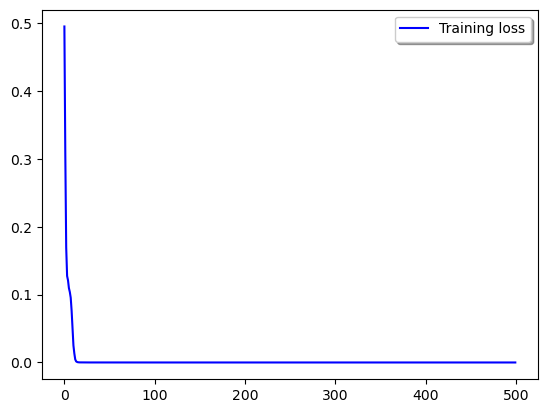

In [11]:
#Vamos ver como foi o treino?
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], color='b', label="Training loss")
legend = plt.legend(loc='best', shadow=True)

## End

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import precision_recall_fscore_support

In [13]:
counter = Model(inputs = [input_dim,input_dim2], outputs = encoded13)
encoded_input = Input(shape = (encoding_dim, ))
unit_values = pd.DataFrame(counter.predict([df_encoder_test,df_features_test]))
unit_values

40/40 [==============================] - 1s 2ms/step


,0
0,1.095141
1,1.547830
2,1.635984
3,1.715101
4,0.173099
...,...
1256,0.711567
1257,0.827169
1258,1.095141
1259,1.095141


In [14]:
counter = Model(inputs = [input_dim,input_dim2], outputs = decoded13)
encoded_input = Input(shape = (encoding_dim, ))

encoded_test = pd.DataFrame(counter.predict([df_encoder_test,df_features_test]))
encoded_test = encoded_test.add_prefix('feature_')



40/40 [==============================] - 0s 4ms/step


In [15]:
mean_absolute_error(encoded_test['feature_0'], df_outs_test['suicatt']), mean_absolute_error(encoded_test['feature_1'], df_outs_test['ideation'])

(0.07295795453382435, 0.07295798387047789)

In [16]:
mean_squared_error(encoded_test['feature_0'], df_outs_test['suicatt']), mean_squared_error(encoded_test['feature_1'], df_outs_test['ideation'])

(0.07295791503476695, 0.0729579406822442)

In [17]:
r2_score(encoded_test['feature_0'], df_outs_test['suicatt']), r2_score(encoded_test['feature_1'], df_outs_test['ideation'])

(0.2873519156381371, -0.7799274699553049)

## Run Counterfactuals

In [33]:
import pandas as pd
import numpy as np
import math
from operator import itemgetter

In [34]:
mutaveis = ['yswdcat', 'yssccat', 'ysadcat', 'ysapcat', 'ysdbcat', 'ysabcat', 'planning', 'cesdcat', 'enbprobs_yes', 'hlthprobs_yes']
columns = ['ysincat', 'ysexcat', 'yswdcat', 'yssccat', 'ysadcat', 'ysapcat', 'ysdbcat', 'ysabcat',  'planning', 'cesdcat', 'enbprobs_yes', 'hlthprobs_yes', 'female', 'age']

In [35]:
def get_fitness(t):
    return t[1]

In [58]:
class Operations:
  def __init__(self, rng):
    self.rng = rng

  def create_pop(self, n):
    #cada indivíduo deve ter uma len = quantidade de atributos mutáveis em X
    pop = self.rng.integers(0, 1, (n, len(mutaveis)), endpoint=True)
    #lista com n indivíduos, cada um sendo uma lista de 0 ou 1 com len = len(mutaveis)
    return pop

  def uni_crossover(self, ind1, ind2):
    #len(ind1) = len(ind2)

    ind1 = np.array(ind1)
    ind2 = np.array(ind2)
    ind_temp = ind1.copy()
    op = self.rng.choice([False, True], len(ind1))

    for iterator, value in enumerate(op):
        if value:

            ind1[iterator]=ind2[iterator]
            ind2[iterator]=ind_temp[iterator]

    return ind1, ind2

  def uni_mutation(self, ind):
    ind = self.rng.choice([0,1], size=len(mutaveis), replace=True)
    return ind

  def operator(self, n, parents, prob_c, prob_m):
    p = 0
    new_pop = []
    while p < n - 2:
        op = self.rng.choice(['c', 'm'], 1, True, [prob_c, prob_m])
        if op == 'c':
            ind1, ind2 = self.uni_crossover(parents[p], parents[p+1])
            new_pop.append(ind1)
            new_pop.append(ind2)
            p += 2
        else:
            ind = self.uni_mutation(parents[p])
            new_pop.append(ind)
            p += 1

    if len(new_pop) == n - 3:
        ind1, ind2 = self.uni_crossover(parents[-3], parents[-2])
        new_pop.append(ind1)
        new_pop.append(ind2)
    elif len(new_pop) == n - 2:
        ind = self.uni_mutation(parents[-2])
        new_pop.append(ind)

    new_pop.append(parents[-1])

    return new_pop

  def result(self, X, y, e, Xcf, model):
    V = X.copy()
    V[['suicatt', 'ideation']] = y
    V[['error_suicatt', 'error_ideation']] = e
    predX = model.predict([V,X])
    predXcf = model.predict([V,Xcf])

    return predX - predXcf

  def fitness(self, pop, X, y, e, model, mut):
    fit = []
    for i in pop:
        rmse = 0
        aux_metrics = []
        Xcf = X.copy()
        for idx in range(len(mut)):
          if i[idx] == 1:
            Xcf[mut[idx]] = (~Xcf[mut[idx]].astype(bool)).astype(int)

        diff = self.result(X, y, e, Xcf, model)
        N = diff.shape[0]
        eval = 0
        for aux in range(N):
          diff1 = diff[aux][0] ** 2
          diff2 = diff[aux][1] ** 2
          eval += (diff1 + diff2)
        rmse = math.sqrt(eval / N)

        fit.append(rmse * (1/sum(i)))

    return fit

  def sort_pop(self, pop, fit):
    sorted_pop = []
    for i in range(len(pop)):
        sorted_pop.append((pop[i], fit[i]))
    sorted_pop.sort(key = get_fitness)
    return sorted_pop

  def tournament(self, k, n, sorted_pop):
    parents = []
    for i in range(n-1):
        aux = self.rng.choice(list(range(len(sorted_pop))), k, False)
        aux_p = []
        for j in aux:
          aux_p.append(sorted_pop[j])
        aux_p.sort(key = get_fitness)
        parents.append(aux_p[-1][0])
    parents.append(sorted_pop[-1][0])
    return parents

In [59]:
def run(rng, tam_pop, qtd_ger, prob_c, prob_m, X, y, e, model, k = 2):
    best_hist = []
    best_ind = -1

    op = Operations(rng)
    pop = op.create_pop(tam_pop)
    fit = op.fitness(pop, X, y, e, model, mutaveis)

    for i in range(qtd_ger):
        sorted_pop = op.sort_pop(pop, fit)
        parents = op.tournament(k, tam_pop, sorted_pop)
        pop = op.operator(tam_pop, parents, prob_c, prob_m)
        fit = op.fitness(pop, X, y, e, model, mutaveis)

        index, _ = max(enumerate(fit), key=itemgetter(1))
        best_hist.append((pop[index], fit[index]))
        if best_ind == -1 or best_ind[1] < fit[index]:
            best_ind = (pop[index], fit[index])

    return best_ind, best_hist

In [61]:
X = V.drop(columns=['suicatt', 'ideation', 'error_suicatt', 'error_ideation'])
y = V[['suicatt', 'ideation']]
e = V[['error_suicatt', 'error_ideation']]
model = Model(inputs = [input_dim,input_dim2], outputs = decoded13)

rng = np.random.default_rng(883)
best_ind, best_hist = run(rng = rng, tam_pop = 100, qtd_ger = 50, prob_c = 0.6, prob_m = 0.4, X = X, y = y, e = e, model = model)
print(best_hist)
print('-'*70)
print(best_ind)

 1/40 [..............................] - ETA: 1s

C:\Users\PLour\AppData\Local\Temp\ipykernel_33744\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_33744\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


 1/40 [..............................] - ETA: 1s

C:\Users\PLour\AppData\Local\Temp\ipykernel_33744\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_33744\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


40/40 [==============================] - 0s 6ms/step


C:\Users\PLour\AppData\Local\Temp\ipykernel_33744\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_33744\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


 1/40 [..............................] - ETA: 1s

C:\Users\PLour\AppData\Local\Temp\ipykernel_33744\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_33744\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


 1/40 [..............................] - ETA: 1s

C:\Users\PLour\AppData\Local\Temp\ipykernel_33744\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_33744\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


 1/40 [..............................] - ETA: 1s

C:\Users\PLour\AppData\Local\Temp\ipykernel_33744\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_33744\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


40/40 [==============================] - 1s 12ms/step


C:\Users\PLour\AppData\Local\Temp\ipykernel_33744\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_33744\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


19/40 [=============>................] - ETA: 0s